In [39]:
import numpy as np
from itertools import product

def independent_market_mechanism(n, m, P):
    """
    Implements the Independent Market Mechanism.

    Parameters:
    - n (int): Number of voters.
    - m (int): Number of alternatives.
    - P (np.array): Voting profile, shape (n, m).

    Returns:
    - allocation (np.array): Final allocation.
    - detailed_info (list): Detailed info for each alternative.
    """
    def compute_sum_medians(t):
        phantoms = np.clip(t * (n - np.arange(n + 1)), 0, 1)
        phantoms = phantoms.tolist()
        total_median = 0
        medians = []
        for i in range(m):
            votes_i = P[:, i].tolist()
            combined_list = votes_i + phantoms
            median_i = np.median(combined_list)
            medians.append(median_i)
            total_median += median_i
        return total_median, medians

    def find_t():
        t_low = 0.0
        t_high = 1.0
        epsilon = 1e-8
        max_iterations = 1000

        for _ in range(max_iterations):
            t_mid = (t_low + t_high) / 2.0
            sum_mid, _ = compute_sum_medians(t_mid)
            if abs(sum_mid - 1.0) < epsilon:
                return t_mid
            elif sum_mid < 1.0:
                t_low = t_mid
            else:
                t_high = t_mid
        print(P)
        raise ValueError("Failed to converge to a solution for t. IMM.")

    # Find the appropriate t
    t = find_t()

    # Compute the final allocation and detailed info
    phantoms = np.clip(t * (n - np.arange(n + 1)), 0, 1)
    phantoms = phantoms.tolist()
    allocation = []
    detailed_info = []
    for i in range(m):
        votes_i = P[:, i].tolist()
        combined_list = votes_i + phantoms
        median_i = np.median(combined_list)
        allocation.append(median_i)
        detailed_info.append({
            'alternative': i + 1,
            'votes': [round(v, 3) for v in votes_i],
            'phantoms': phantoms,
            'combined_list': sorted([round(x, 3) for x in combined_list]),
            'median': median_i
        })

    allocation = np.array(allocation)
    return allocation, detailed_info

def welfare_maximizing_phantom_mechanism(n, m, P):
    """
    Implements the Welfare-Maximizing Phantom Mechanism.

    Parameters:
    - n (int): Number of voters.
    - m (int): Number of alternatives.
    - P (np.array): Voting profile, shape (n, m).

    Returns:
    - allocation (np.array): Final allocation.
    - detailed_info (list): Detailed info for each alternative.
    """
    def compute_phantoms(t):
        k_values = np.arange(n + 1)
        fk = np.zeros(n + 1)
        condition1 = t <= k_values / (n + 1)
        condition2 = (t > k_values / (n + 1)) & (t <= (k_values + 1) / (n + 1))
        condition3 = t > (k_values + 1) / (n + 1)

        fk[condition1] = 0
        fk[condition2] = (n + 1) * t - k_values[condition2]
        fk[condition3] = 1
        return fk.tolist()

    def compute_sum_medians(t):
        phantoms = compute_phantoms(t)
        total_median = 0
        medians = []
        for i in range(m):
            votes_i = P[:, i].tolist()
            combined_list = votes_i + phantoms
            median_i = np.median(combined_list)
            medians.append(median_i)
            total_median += median_i
        return total_median, medians

    def find_t():
        t_low = 0.0
        t_high = 1.0
        epsilon = 1e-8
        max_iterations = 1000

        for _ in range(max_iterations):
            t_mid = (t_low + t_high) / 2.0
            sum_mid, _ = compute_sum_medians(t_mid)
            if abs(sum_mid - 1.0) < epsilon:
                return t_mid
            elif sum_mid > 1.0:
                t_high = t_mid
            else:
                t_low = t_mid
        raise ValueError("Failed to converge to a solution for t. WMM")

    # Find the appropriate t
    t = find_t()

    # Compute the final allocation and detailed info
    phantoms = compute_phantoms(t)
    allocation = []
    detailed_info = []
    for i in range(m):
        votes_i = P[:, i].tolist()
        combined_list = votes_i + phantoms
        median_i = np.median(combined_list)
        allocation.append(median_i)
        detailed_info.append({
            'alternative': i + 1,
            'votes': [round(v, 3) for v in votes_i],
            'phantoms': phantoms,
            'combined_list': sorted([round(x, 3) for x in combined_list]),
            'median': median_i
        })

    allocation = np.array(allocation)
    return allocation, detailed_info

def compute_disutilities(P, allocation,type):

    disutilities = np.sum(np.abs(P - allocation), axis=1)
    if type == 'welfare':
        return disutilities
    elif type == 'fairness':
        return np.max(disutilities)


def combined_allocation_and_loss(n, m, P):
    """
    Computes the combined allocation, welfare loss, and fairness loss, along with intermediate results.

    Parameters:
    - n (int): Number of voters.
    - m (int): Number of alternatives.
    - P (np.array): Voting profile, shape (n, m).

    Returns:
    - dict: Contains combined allocation, welfare losses, fairness losses, allocations, and disutilities.
    """
    # Compute allocations for IMM and WMPM
    allocation_IMM, _ = independent_market_mechanism(n, m, P)
    allocation_WMPM, _ = welfare_maximizing_phantom_mechanism(n, m, P)

    allocation_IMM = np.round(allocation_IMM,3)
    allocation_WMPM = np.round(allocation_WMPM,3)

    # Combine the allocations equally
    allocation_C = np.round((allocation_IMM + allocation_WMPM) / 2, 3)

    # Compute welfare disutilities
    total_disutility_IMM = np.round(np.sum(compute_disutilities(P, allocation_IMM, type="welfare")),3)
    total_disutility_WMPM = np.round(np.sum(compute_disutilities(P, allocation_WMPM, type="welfare")),3)
    total_disutility_C = np.round(np.sum(compute_disutilities(P, allocation_C, type="welfare")),3)

    # Calculate welfare loss
    welfare_loss_IMM = total_disutility_C - total_disutility_IMM
    welfare_loss_WMPM = total_disutility_C - total_disutility_WMPM

    # Compute fairness disutilities
    max_disutility_IMM = np.round(compute_disutilities(P, allocation_IMM, type="fairness"),3)
    max_disutility_WMPM = np.round(compute_disutilities(P, allocation_WMPM, type="fairness"),3)
    max_disutility_C = np.round(compute_disutilities(P, allocation_C, type="fairness"),3)

    # Calculate fairness loss
    fairness_loss_IMM = max_disutility_C - max_disutility_IMM
    fairness_loss_WMPM = max_disutility_C - max_disutility_WMPM

    # Return results
    return {
        "allocation_IMM": allocation_IMM,
        "allocation_WMPM": allocation_WMPM,
        "combined_allocation": allocation_C,
        "total_disutility_IMM": total_disutility_IMM,
        "total_disutility_WMPM": total_disutility_WMPM,
        "total_disutility_C": total_disutility_C,
        "max_disutility_IMM": max_disutility_IMM,
        "max_disutility_WMPM": max_disutility_WMPM,
        "max_disutility_C": max_disutility_C,
        "welfare_loss_IMM": welfare_loss_IMM,
        "welfare_loss_WMPM": welfare_loss_WMPM,
        "fairness_loss_IMM": fairness_loss_IMM,
        "fairness_loss_WMPM": fairness_loss_WMPM,
    }

def generate_random_preferences(n, m):
    P = np.random.rand(n, m)
    # Normalize each voter's preferences to sum to 1
    P = P / P.sum(axis=1, keepdims=True)
    return np.round(P, 2)

def generate_single_voter_preferences(m):
    total = 10  # Scale to 10 to work with integers
    preferences = []
    if m ==3:
        for p1 in range(total + 1):
            for p2 in range(total - p1 + 1):
                p3 = total - p1 - p2
                preferences.append((p1 / 10, p2 / 10, p3 / 10))
        return preferences
    elif m ==2:
        for p1 in range(total+1):
            p2 = total - p1
            preferences.append((p1 / 10, p2 / 10))
        return preferences

def generate_all_voter_profiles(n,m):
    single_voter_preferences = generate_single_voter_preferences(m)
    return product(single_voter_preferences, repeat=n)   


In [30]:
import pandas as pd
def generate_data(n, m):
    """
    Generates data for all voter profiles and their respective allocations and losses.

    Parameters:
    - n (int): Number of voters.
    - m (int): Number of alternatives.

    Returns:
    - pd.DataFrame: DataFrame containing allocations, losses, and disutilities.
    """
    all_profiles = generate_all_voter_profiles(n, m)
    results = []
    
    for profile in all_profiles:
        P = np.array(profile)  # Convert profile to numpy array (n x m)
        
        # Call the function and directly get the dictionary
        results_dict = combined_allocation_and_loss(n, m, P)
        
        # Append results to the list
        results.append({
            'P': P,
            'allocation_IMM': results_dict["allocation_IMM"],
            'allocation_WMPM': results_dict["allocation_WMPM"],
            'allocation_C': results_dict["combined_allocation"],
            'total_disutility_IMM': results_dict["total_disutility_IMM"],
            'total_disutility_WMPM': results_dict["total_disutility_WMPM"],
            'total_disutility_C': results_dict["total_disutility_C"],
            'max_disutility_IMM': results_dict["max_disutility_IMM"],
            'max_disutility_WMPM': results_dict["max_disutility_WMPM"],
            'max_disutility_C': results_dict["max_disutility_C"],
            'welfare_loss_IMM': round(results_dict["welfare_loss_IMM"], 3),
            'welfare_loss_WMPM': round(results_dict["welfare_loss_WMPM"], 3),
            'fairness_loss_IMM': round(results_dict["fairness_loss_IMM"], 3),
            'fairness_loss_WMPM': round(results_dict["fairness_loss_WMPM"], 3),
        })
    
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(results)
    return df

In [ ]:
pd.set_option('display.max_colwidth', None)

In [138]:
df = generate_data(3,2)

In [84]:
df.head()

,P,allocation_IMM,allocation_WMPM,allocation_C,total_disutility_IMM,total_disutility_WMPM,total_disutility_C,max_disutility_IMM,max_disutility_WMPM,max_disutility_C,welfare_loss_IMM,welfare_loss_WMPM,fairness_loss_IMM,fairness_loss_WMPM
0,"[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]",0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
1,"[[0.0, 1.0], [0.0, 1.0], [0.1, 0.9]]","[0.1, 0.9]","[0.0, 1.0]","[0.05, 0.95]",0.400,0.2,0.300,0.200,0.2,0.100,-0.100,0.100,-0.100,-0.100
2,"[[0.0, 1.0], [0.0, 1.0], [0.2, 0.8]]","[0.2, 0.8]","[0.0, 1.0]","[0.1, 0.9]",0.800,0.4,0.600,0.400,0.4,0.200,-0.200,0.200,-0.200,-0.200
3,"[[0.0, 1.0], [0.0, 1.0], [0.3, 0.7]]","[0.3, 0.7]","[0.0, 1.0]","[0.15, 0.85]",1.200,0.6,0.900,0.600,0.6,0.300,-0.300,0.300,-0.300,-0.300
4,"[[0.0, 1.0], [0.0, 1.0], [0.4, 0.6]]","[0.333, 0.667]","[0.0, 1.0]","[0.166, 0.834]",1.466,0.8,1.132,0.666,0.8,0.468,-0.334,0.332,-0.198,-0.332


In [87]:
efficiency_col = list(range(0, 7)) + [10, 11]
df2 = df.iloc[:, efficiency_col]
df2['diff'] = df2['welfare_loss_IMM'] + df2['welfare_loss_WMPM']

fairness_col = list(range(0, 4)) + [7, 8,9,12,13]
df3 = df.iloc[:, fairness_col]
df3['diff'] = df3['fairness_loss_IMM'] + df3['fairness_loss_WMPM']

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24992\1054402636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['diff'] = df2['welfare_loss_IMM'] + df2['welfare_loss_WMPM']
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24992\1054402636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['diff'] = df3['fairness_loss_IMM'] + df3['fairness_loss_WMPM']


In [190]:
df2['sum'] = df2['welfare_loss_IMM'] + df2['welfare_loss_WMPM']
df2.head()

,P,allocation_IMM,allocation_WMPM,allocation_C,total_disutility_IMM,total_disutility_WMPM,total_disutility_C,welfare_loss_IMM,welfare_loss_WMPM,sum
0,"[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]",0.000,0.0,0.000,0.000,0.000,0.000
1,"[[0.0, 1.0], [0.0, 1.0], [0.1, 0.9]]","[0.1, 0.9]","[0.0, 1.0]","[0.05, 0.95]",0.400,0.2,0.300,-0.100,0.100,0.000
2,"[[0.0, 1.0], [0.0, 1.0], [0.2, 0.8]]","[0.2, 0.8]","[0.0, 1.0]","[0.1, 0.9]",0.800,0.4,0.600,-0.200,0.200,0.000
3,"[[0.0, 1.0], [0.0, 1.0], [0.3, 0.7]]","[0.3, 0.7]","[0.0, 1.0]","[0.15, 0.85]",1.200,0.6,0.900,-0.300,0.300,0.000
4,"[[0.0, 1.0], [0.0, 1.0], [0.4, 0.6]]","[0.333, 0.667]","[0.0, 1.0]","[0.166, 0.834]",1.466,0.8,1.132,-0.334,0.332,-0.002


In [ ]:
df4 = generate_data(3,3)


In [209]:
df4['total_disutility_IMM']=np.round(df4['total_disutility_IMM'],3)
df4['total_disutility_WMPM']=np.round(df4['total_disutility_WMPM'],3)
df4['total_disutility_C']=np.round(df4['total_disutility_C'],3)
df4['welfare_loss_IMM']=np.round(df4['welfare_loss_IMM'],3)
df4['welfare_loss_WMPM']=np.round(df4['welfare_loss_WMPM'],3)

In [216]:
df5 = df4.iloc[:, efficiency_col]
df5['sum'] = np.round(df5['welfare_loss_IMM'] + df5['welfare_loss_WMPM'],3)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24992\4004145974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['sum'] = np.round(df5['welfare_loss_IMM'] + df5['welfare_loss_WMPM'],3)


In [229]:
df6 = df4.iloc[:, fairness_col]

Welfare

In [192]:
df2['sum'].value_counts()

sum
 0.000    785
-0.002    546
Name: count, dtype: int64

In [211]:
df5['sum'].value_counts()

sum
 0.000    256302
-0.002     14958
 0.002     14436
 0.004       702
-0.200       450
-0.002       198
-0.148       162
-0.052       126
-0.050        72
-0.052        54
-0.050        36
Name: count, dtype: int64

In [221]:
df5[df5['sum']==-0.2]

,P,allocation_IMM,allocation_WMPM,allocation_C,total_disutility_IMM,total_disutility_WMPM,total_disutility_C,welfare_loss_IMM,welfare_loss_WMPM,sum
87,"[[0.0, 0.0, 1.0], [0.0, 0.1, 0.9], [0.2, 0.0, 0.8]]","[0.2, 0.1, 0.7]","[0.05, 0.05, 0.9]","[0.125, 0.075, 0.8]",1.2,0.6,0.8,-0.4,0.2,-0.2
143,"[[0.0, 0.0, 1.0], [0.0, 0.2, 0.8], [0.1, 0.0, 0.9]]","[0.1, 0.2, 0.7]","[0.05, 0.05, 0.9]","[0.075, 0.125, 0.8]",1.2,0.6,0.8,-0.4,0.2,-0.2
154,"[[0.0, 0.0, 1.0], [0.0, 0.2, 0.8], [0.2, 0.1, 0.7]]","[0.2, 0.2, 0.6]","[0.1, 0.1, 0.8]","[0.15, 0.15, 0.7]",1.4,0.8,1.0,-0.4,0.2,-0.2
162,"[[0.0, 0.0, 1.0], [0.0, 0.2, 0.8], [0.3, 0.0, 0.7]]","[0.2, 0.2, 0.6]","[0.1, 0.1, 0.8]","[0.15, 0.15, 0.7]",1.6,1.0,1.2,-0.4,0.2,-0.2
219,"[[0.0, 0.0, 1.0], [0.0, 0.3, 0.7], [0.2, 0.0, 0.8]]","[0.2, 0.2, 0.6]","[0.1, 0.1, 0.8]","[0.15, 0.15, 0.7]",1.6,1.0,1.2,-0.4,0.2,-0.2
...,...,...,...,...,...,...,...,...,...,...
287288,"[[1.0, 0.0, 0.0], [0.8, 0.2, 0.0], [0.7, 0.0, 0.3]]","[0.6, 0.2, 0.2]","[0.8, 0.1, 0.1]","[0.7, 0.15, 0.15]",1.6,1.0,1.2,-0.4,0.2,-0.2
287289,"[[1.0, 0.0, 0.0], [0.8, 0.2, 0.0], [0.7, 0.1, 0.2]]","[0.6, 0.2, 0.2]","[0.8, 0.1, 0.1]","[0.7, 0.15, 0.15]",1.4,0.8,1.0,-0.4,0.2,-0.2
287295,"[[1.0, 0.0, 0.0], [0.8, 0.2, 0.0], [0.9, 0.0, 0.1]]","[0.7, 0.2, 0.1]","[0.9, 0.05, 0.05]","[0.8, 0.125, 0.075]",1.2,0.6,0.8,-0.4,0.2,-0.2
287360,"[[1.0, 0.0, 0.0], [0.9, 0.0, 0.1], [0.8, 0.2, 0.0]]","[0.7, 0.2, 0.1]","[0.9, 0.05, 0.05]","[0.8, 0.125, 0.075]",1.2,0.6,0.8,-0.4,0.2,-0.2


In [226]:
max(df5['welfare_loss_WMPM'])

0.5

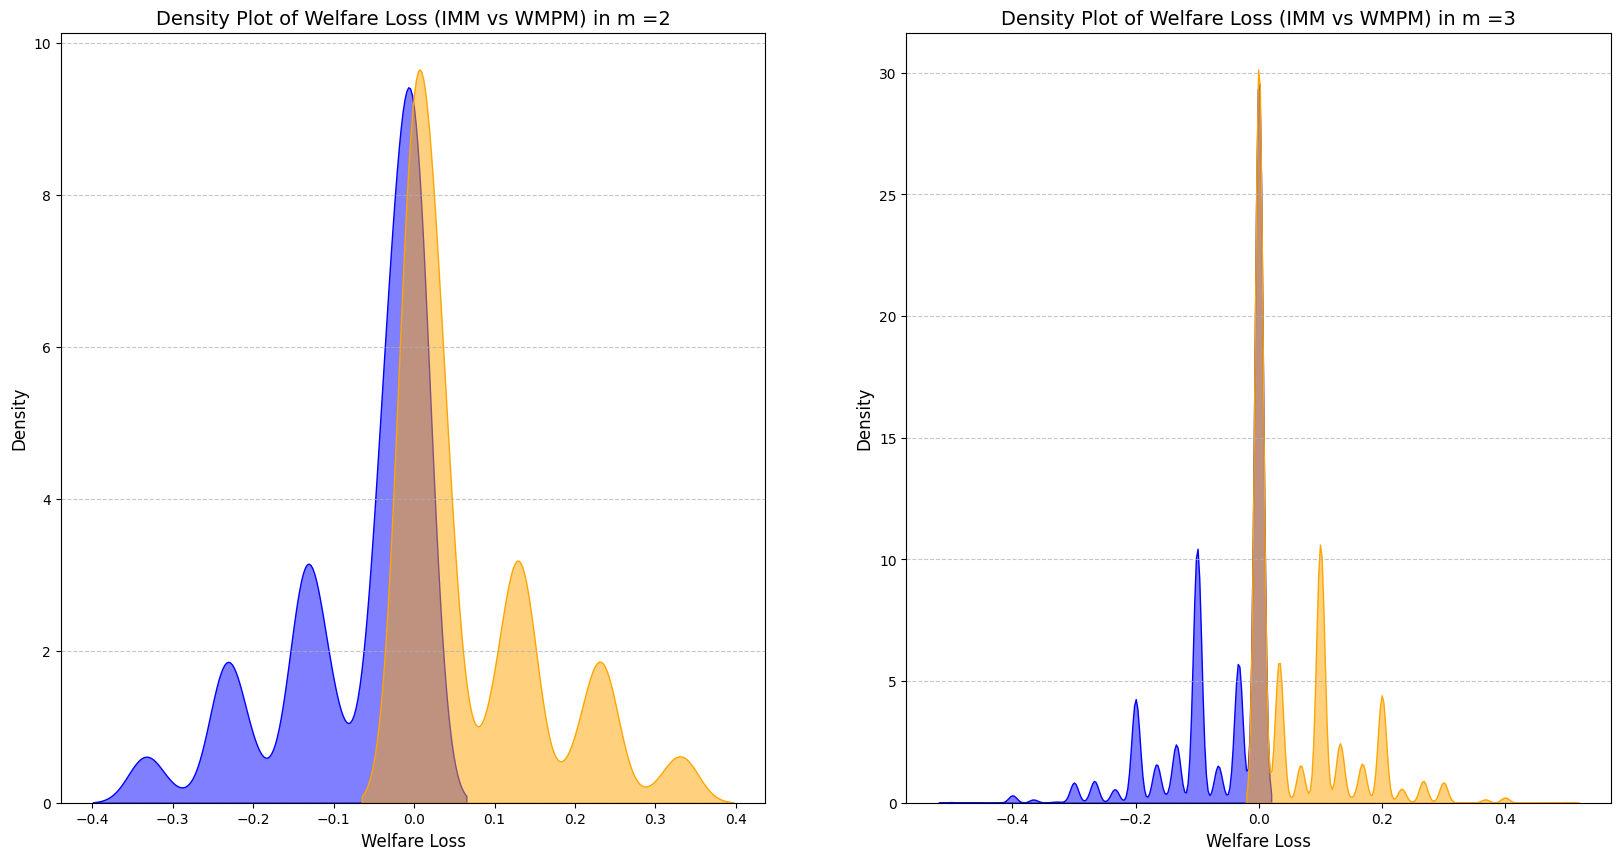

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 

sns.kdeplot(df2['welfare_loss_IMM'], fill=True, ax=axes[0], label='IMM', color='blue', alpha=0.5)

# Plot KDE for welfare_loss_WMPM
sns.kdeplot(df2['welfare_loss_WMPM'], fill=True, ax=axes[0], label='WMPM', color='orange', alpha=0.5)

# Add title, labels, and grid
axes[0].set_title('Density Plot of Welfare Loss (IMM vs WMPM) in m =2', fontsize=14)
axes[0].set_xlabel('Welfare Loss', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.kdeplot(df5['welfare_loss_IMM'], fill=True, ax=axes[1], label='IMM', color='blue', alpha=0.5)

# Plot KDE for welfare_loss_WMPM
sns.kdeplot(df5['welfare_loss_WMPM'], fill=True, ax=axes[1], label='WMPM', color='orange', alpha=0.5)

# Add title, labels, and grid
axes[1].set_title('Density Plot of Welfare Loss (IMM vs WMPM) in m =3', fontsize=14)
axes[1].set_xlabel('Welfare Loss', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

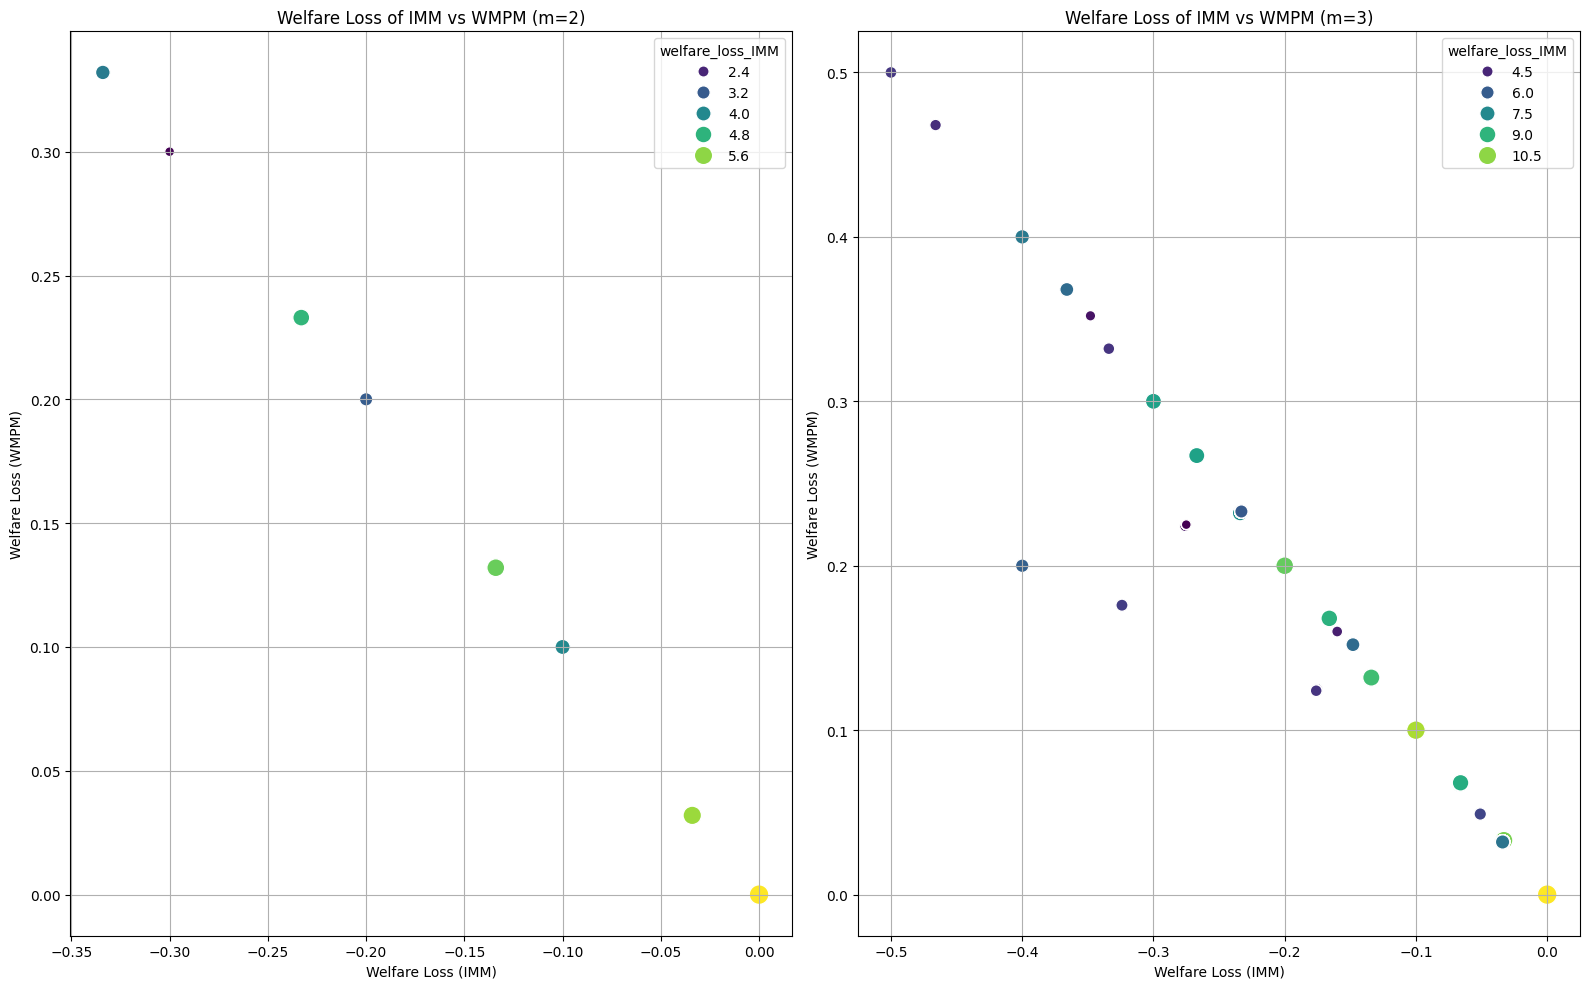

In [269]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

log_transform = lambda x: np.log1p(x)

sns.scatterplot(
    data=df,
    x='welfare_loss_IMM',
    y='welfare_loss_WMPM',
    size=log_transform(df.groupby(['welfare_loss_IMM', 'welfare_loss_WMPM'])['welfare_loss_IMM'].transform('count')),
    hue=log_transform(df.groupby(['welfare_loss_IMM', 'welfare_loss_WMPM'])['welfare_loss_IMM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[0]
)
axes[0].set_title('Welfare Loss of IMM vs WMPM (m=2)')
axes[0].set_xlabel('Welfare Loss (IMM)')
axes[0].set_ylabel('Welfare Loss (WMPM)')
axes[0].grid(True)

# Plot for welfare loss of IMM vs WMPM (m=3) with dynamic frequency calculation
sns.scatterplot(
    data=df4,
    x='welfare_loss_IMM',
    y='welfare_loss_WMPM',
    size=log_transform(df4.groupby(['welfare_loss_IMM', 'welfare_loss_WMPM'])['welfare_loss_IMM'].transform('count')),
    hue=log_transform(df4.groupby(['welfare_loss_IMM', 'welfare_loss_WMPM'])['welfare_loss_IMM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[1]
)
axes[1].set_title('Welfare Loss of IMM vs WMPM (m=3)')
axes[1].set_xlabel('Welfare Loss (IMM)')
axes[1].set_ylabel('Welfare Loss (WMPM)')
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


Fariness

In [232]:
df3.drop(columns=['sum'])

,P,allocation_IMM,allocation_WMPM,allocation_C,max_disutility_IMM,max_disutility_WMPM,max_disutility_C,fairness_loss_IMM,fairness_loss_WMPM
0,"[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]",0.000,0.0,0.000,0.000,0.000
1,"[[0.0, 1.0], [0.0, 1.0], [0.1, 0.9]]","[0.1, 0.9]","[0.0, 1.0]","[0.05, 0.95]",0.200,0.2,0.100,-0.100,-0.100
2,"[[0.0, 1.0], [0.0, 1.0], [0.2, 0.8]]","[0.2, 0.8]","[0.0, 1.0]","[0.1, 0.9]",0.400,0.4,0.200,-0.200,-0.200
3,"[[0.0, 1.0], [0.0, 1.0], [0.3, 0.7]]","[0.3, 0.7]","[0.0, 1.0]","[0.15, 0.85]",0.600,0.6,0.300,-0.300,-0.300
4,"[[0.0, 1.0], [0.0, 1.0], [0.4, 0.6]]","[0.333, 0.667]","[0.0, 1.0]","[0.166, 0.834]",0.666,0.8,0.468,-0.198,-0.332
...,...,...,...,...,...,...,...,...,...
1326,"[[1.0, 0.0], [1.0, 0.0], [0.6, 0.4]]","[0.667, 0.333]","[1.0, 0.0]","[0.834, 0.166]",0.666,0.8,0.468,-0.198,-0.332
1327,"[[1.0, 0.0], [1.0, 0.0], [0.7, 0.3]]","[0.7, 0.3]","[1.0, 0.0]","[0.85, 0.15]",0.600,0.6,0.300,-0.300,-0.300
1328,"[[1.0, 0.0], [1.0, 0.0], [0.8, 0.2]]","[0.8, 0.2]","[1.0, 0.0]","[0.9, 0.1]",0.400,0.4,0.200,-0.200,-0.200
1329,"[[1.0, 0.0], [1.0, 0.0], [0.9, 0.1]]","[0.9, 0.1]","[1.0, 0.0]","[0.95, 0.05]",0.200,0.2,0.100,-0.100,-0.100


In [230]:
df6

,P,allocation_IMM,allocation_WMPM,allocation_C,max_disutility_IMM,max_disutility_WMPM,max_disutility_C,fairness_loss_IMM,fairness_loss_WMPM
0,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.000,0.0,0.000,0.000,0.000
1,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.1, 0.9]]","[0.0, 0.1, 0.9]","[0.0, 0.0, 1.0]","[0.0, 0.05, 0.95]",0.200,0.2,0.100,-0.100,-0.100
2,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.2, 0.8]]","[0.0, 0.2, 0.8]","[0.0, 0.0, 1.0]","[0.0, 0.1, 0.9]",0.400,0.4,0.200,-0.200,-0.200
3,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.3, 0.7]]","[0.0, 0.3, 0.7]","[0.0, 0.0, 1.0]","[0.0, 0.15, 0.85]",0.600,0.6,0.300,-0.300,-0.300
4,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.4, 0.6]]","[0.0, 0.333, 0.667]","[0.0, 0.0, 1.0]","[0.0, 0.166, 0.834]",0.666,0.8,0.468,-0.198,-0.332
...,...,...,...,...,...,...,...,...,...
287491,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.8, 0.1, 0.1]]","[0.8, 0.1, 0.1]","[1.0, 0.0, 0.0]","[0.9, 0.05, 0.05]",0.400,0.4,0.200,-0.200,-0.200
287492,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]]","[0.8, 0.2, 0.0]","[1.0, 0.0, 0.0]","[0.9, 0.1, 0.0]",0.400,0.4,0.200,-0.200,-0.200
287493,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.9, 0.0, 0.1]]","[0.9, 0.0, 0.1]","[1.0, 0.0, 0.0]","[0.95, 0.0, 0.05]",0.200,0.2,0.100,-0.100,-0.100
287494,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.9, 0.1, 0.0]]","[0.9, 0.1, 0.0]","[1.0, 0.0, 0.0]","[0.95, 0.05, 0.0]",0.200,0.2,0.100,-0.100,-0.100


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24992\701399126.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Metric', y='Fairness Loss', palette='viridis')


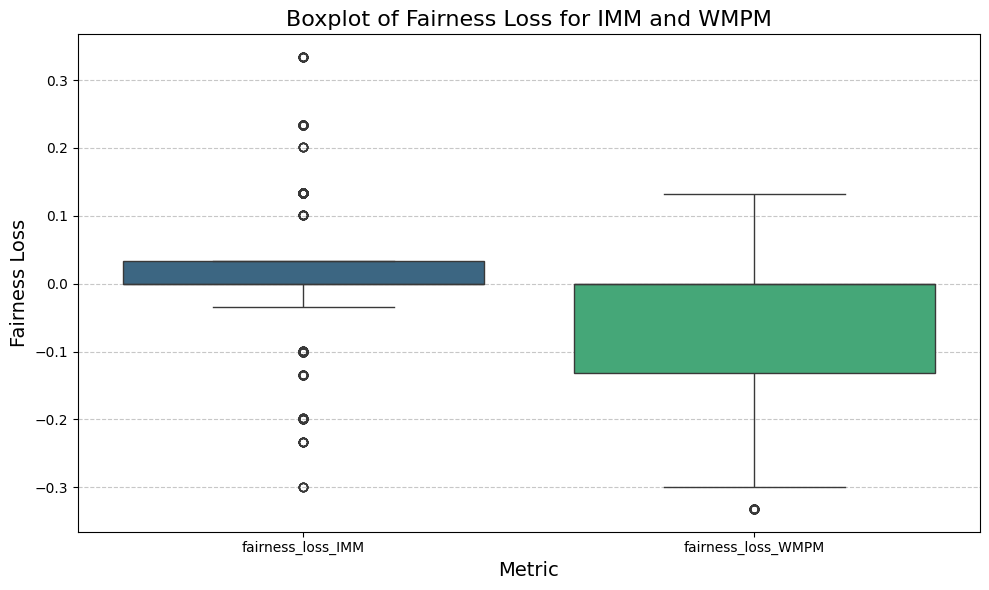

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new DataFrame for easier plotting
data_to_plot = df3[['fairness_loss_IMM', 'fairness_loss_WMPM']].melt(
    var_name='Metric',
    value_name='Fairness Loss'
)

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot, x='Metric', y='Fairness Loss', palette='viridis')

# Add title and labels
plt.title('Boxplot of Fairness Loss for IMM and WMPM', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Fairness Loss', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


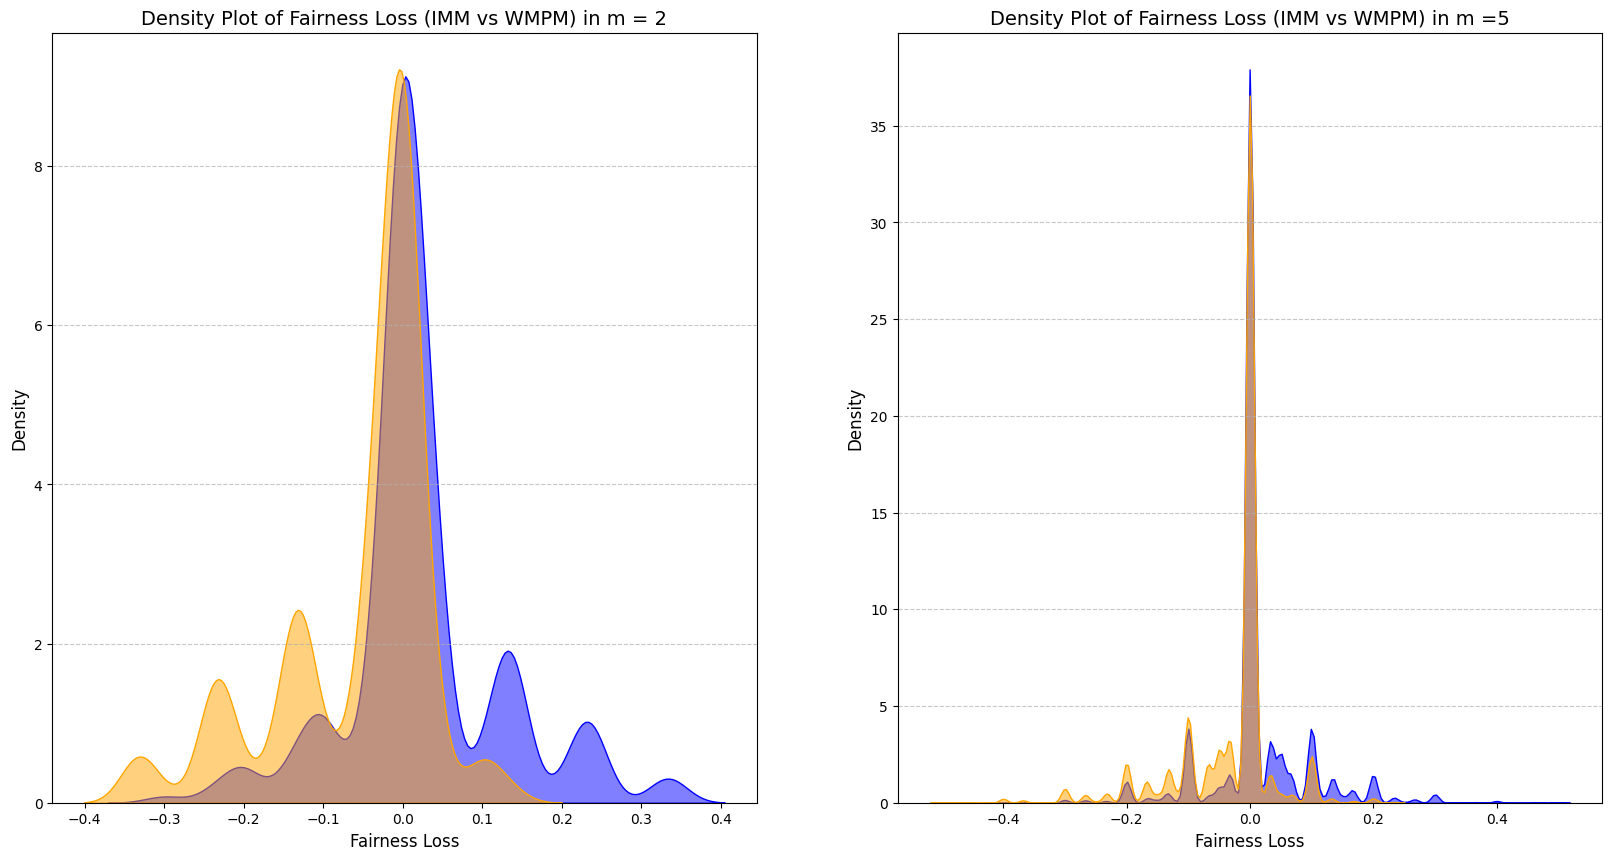

In [245]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 

sns.kdeplot(df3['fairness_loss_IMM'], fill=True, ax=axes[0], label='IMM', color='blue', alpha=0.5)

# Plot KDE for welfare_loss_WMPM
sns.kdeplot(df3['fairness_loss_WMPM'], fill=True, ax=axes[0], label='WMPM', color='orange', alpha=0.5)

# Add title, labels, and grid
axes[0].set_title('Density Plot of Fairness Loss (IMM vs WMPM) in m = 2', fontsize=14)
axes[0].set_xlabel('Fairness Loss', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.kdeplot(df6['fairness_loss_IMM'], fill=True, ax=axes[1], label='IMM', color='blue', alpha=0.5)

# Plot KDE for welfare_loss_WMPM
sns.kdeplot(df6['fairness_loss_WMPM'], fill=True, ax=axes[1], label='WMPM', color='orange', alpha=0.5)

# Add title, labels, and grid
axes[1].set_title('Density Plot of Fairness Loss (IMM vs WMPM) in m =5', fontsize=14)
axes[1].set_xlabel('Fairness Loss', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

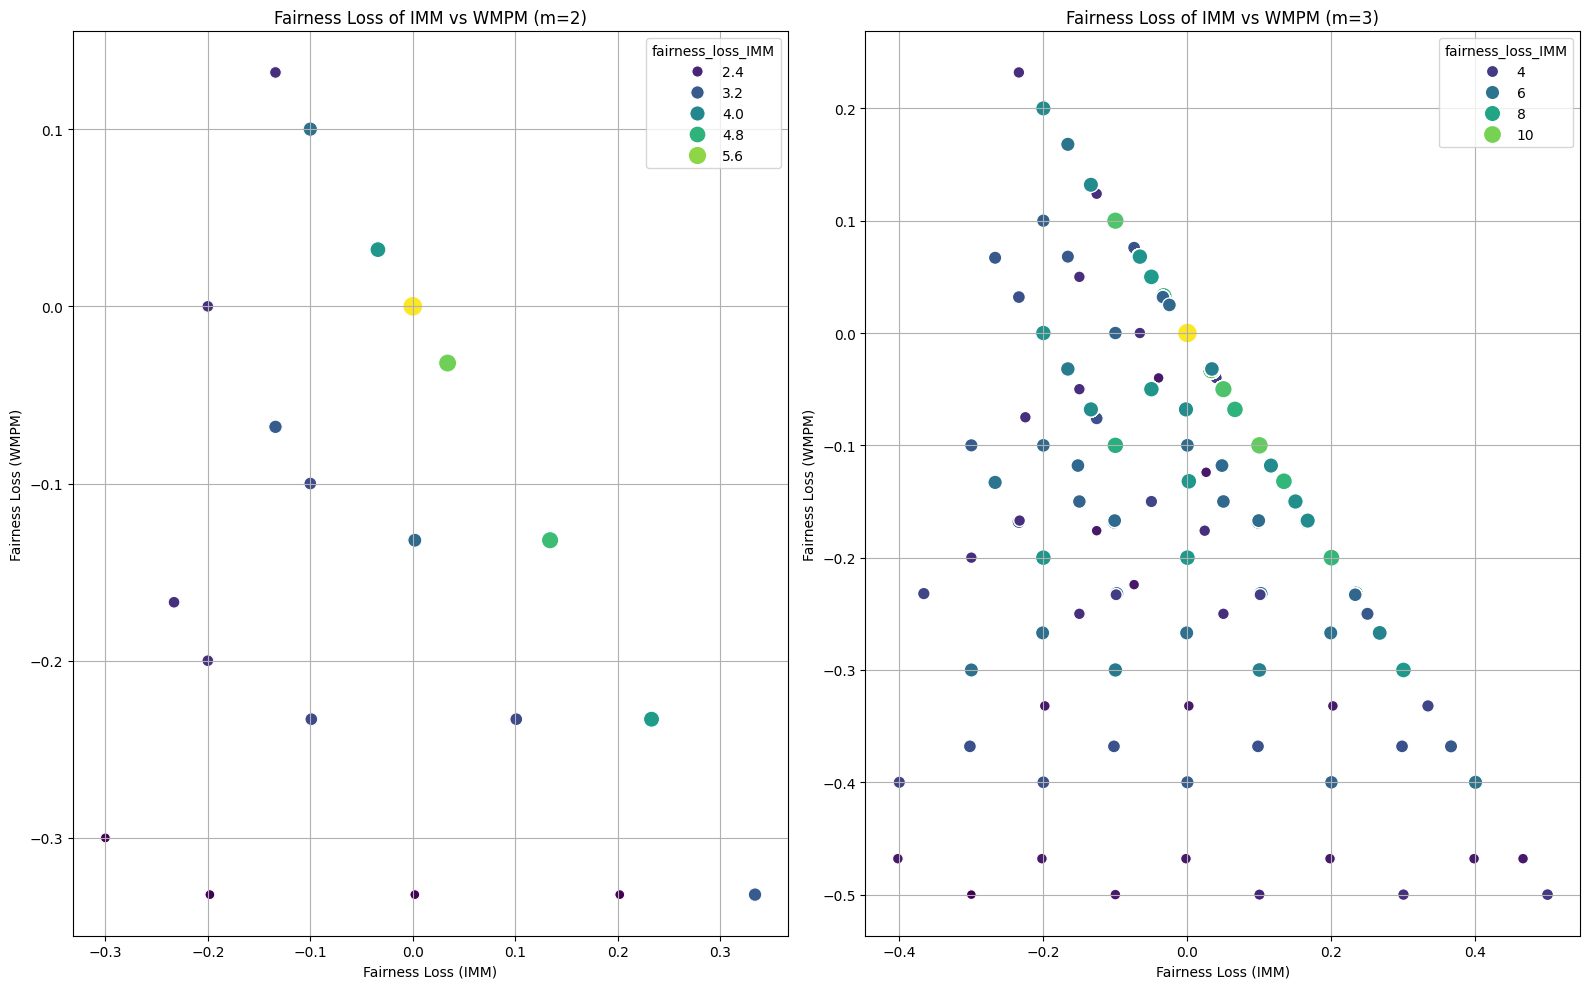

In [268]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

log_transform = lambda x: np.log1p(x)

sns.scatterplot(
    data=df,
    x='fairness_loss_IMM',
    y='fairness_loss_WMPM',
    size=log_transform(df.groupby(['fairness_loss_IMM', 'fairness_loss_WMPM'])['fairness_loss_IMM'].transform('count')),
    hue=log_transform(df.groupby(['fairness_loss_IMM', 'fairness_loss_WMPM'])['fairness_loss_IMM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[0]
)
axes[0].set_title('Fairness Loss of IMM vs WMPM (m=2)')
axes[0].set_xlabel('Fairness Loss (IMM)')
axes[0].set_ylabel('Fairness Loss (WMPM)')
axes[0].grid(True)

# Plot for fairness loss of IMM vs WMPM (m=3) with dynamic frequency calculation
sns.scatterplot(
    data=df4,
    x='fairness_loss_IMM',
    y='fairness_loss_WMPM',
    size=log_transform(df4.groupby(['fairness_loss_IMM', 'fairness_loss_WMPM'])['fairness_loss_IMM'].transform('count')),
    hue=log_transform(df4.groupby(['fairness_loss_IMM', 'fairness_loss_WMPM'])['fairness_loss_IMM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[1]
)
axes[1].set_title('Fairness Loss of IMM vs WMPM (m=3)')
axes[1].set_xlabel('Fairness Loss (IMM)')
axes[1].set_ylabel('Fairness Loss (WMPM)')
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()



Trade-off

In [250]:
df

,P,allocation_IMM,allocation_WMPM,allocation_C,total_disutility_IMM,total_disutility_WMPM,total_disutility_C,max_disutility_IMM,max_disutility_WMPM,max_disutility_C,welfare_loss_IMM,welfare_loss_WMPM,fairness_loss_IMM,fairness_loss_WMPM
0,"[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]",0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
1,"[[0.0, 1.0], [0.0, 1.0], [0.1, 0.9]]","[0.1, 0.9]","[0.0, 1.0]","[0.05, 0.95]",0.400,0.2,0.300,0.200,0.2,0.100,-0.100,0.100,-0.100,-0.100
2,"[[0.0, 1.0], [0.0, 1.0], [0.2, 0.8]]","[0.2, 0.8]","[0.0, 1.0]","[0.1, 0.9]",0.800,0.4,0.600,0.400,0.4,0.200,-0.200,0.200,-0.200,-0.200
3,"[[0.0, 1.0], [0.0, 1.0], [0.3, 0.7]]","[0.3, 0.7]","[0.0, 1.0]","[0.15, 0.85]",1.200,0.6,0.900,0.600,0.6,0.300,-0.300,0.300,-0.300,-0.300
4,"[[0.0, 1.0], [0.0, 1.0], [0.4, 0.6]]","[0.333, 0.667]","[0.0, 1.0]","[0.166, 0.834]",1.466,0.8,1.132,0.666,0.8,0.468,-0.334,0.332,-0.198,-0.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,"[[1.0, 0.0], [1.0, 0.0], [0.6, 0.4]]","[0.667, 0.333]","[1.0, 0.0]","[0.834, 0.166]",1.466,0.8,1.132,0.666,0.8,0.468,-0.334,0.332,-0.198,-0.332
1327,"[[1.0, 0.0], [1.0, 0.0], [0.7, 0.3]]","[0.7, 0.3]","[1.0, 0.0]","[0.85, 0.15]",1.200,0.6,0.900,0.600,0.6,0.300,-0.300,0.300,-0.300,-0.300
1328,"[[1.0, 0.0], [1.0, 0.0], [0.8, 0.2]]","[0.8, 0.2]","[1.0, 0.0]","[0.9, 0.1]",0.800,0.4,0.600,0.400,0.4,0.200,-0.200,0.200,-0.200,-0.200
1329,"[[1.0, 0.0], [1.0, 0.0], [0.9, 0.1]]","[0.9, 0.1]","[1.0, 0.0]","[0.95, 0.05]",0.400,0.2,0.300,0.200,0.2,0.100,-0.100,0.100,-0.100,-0.100


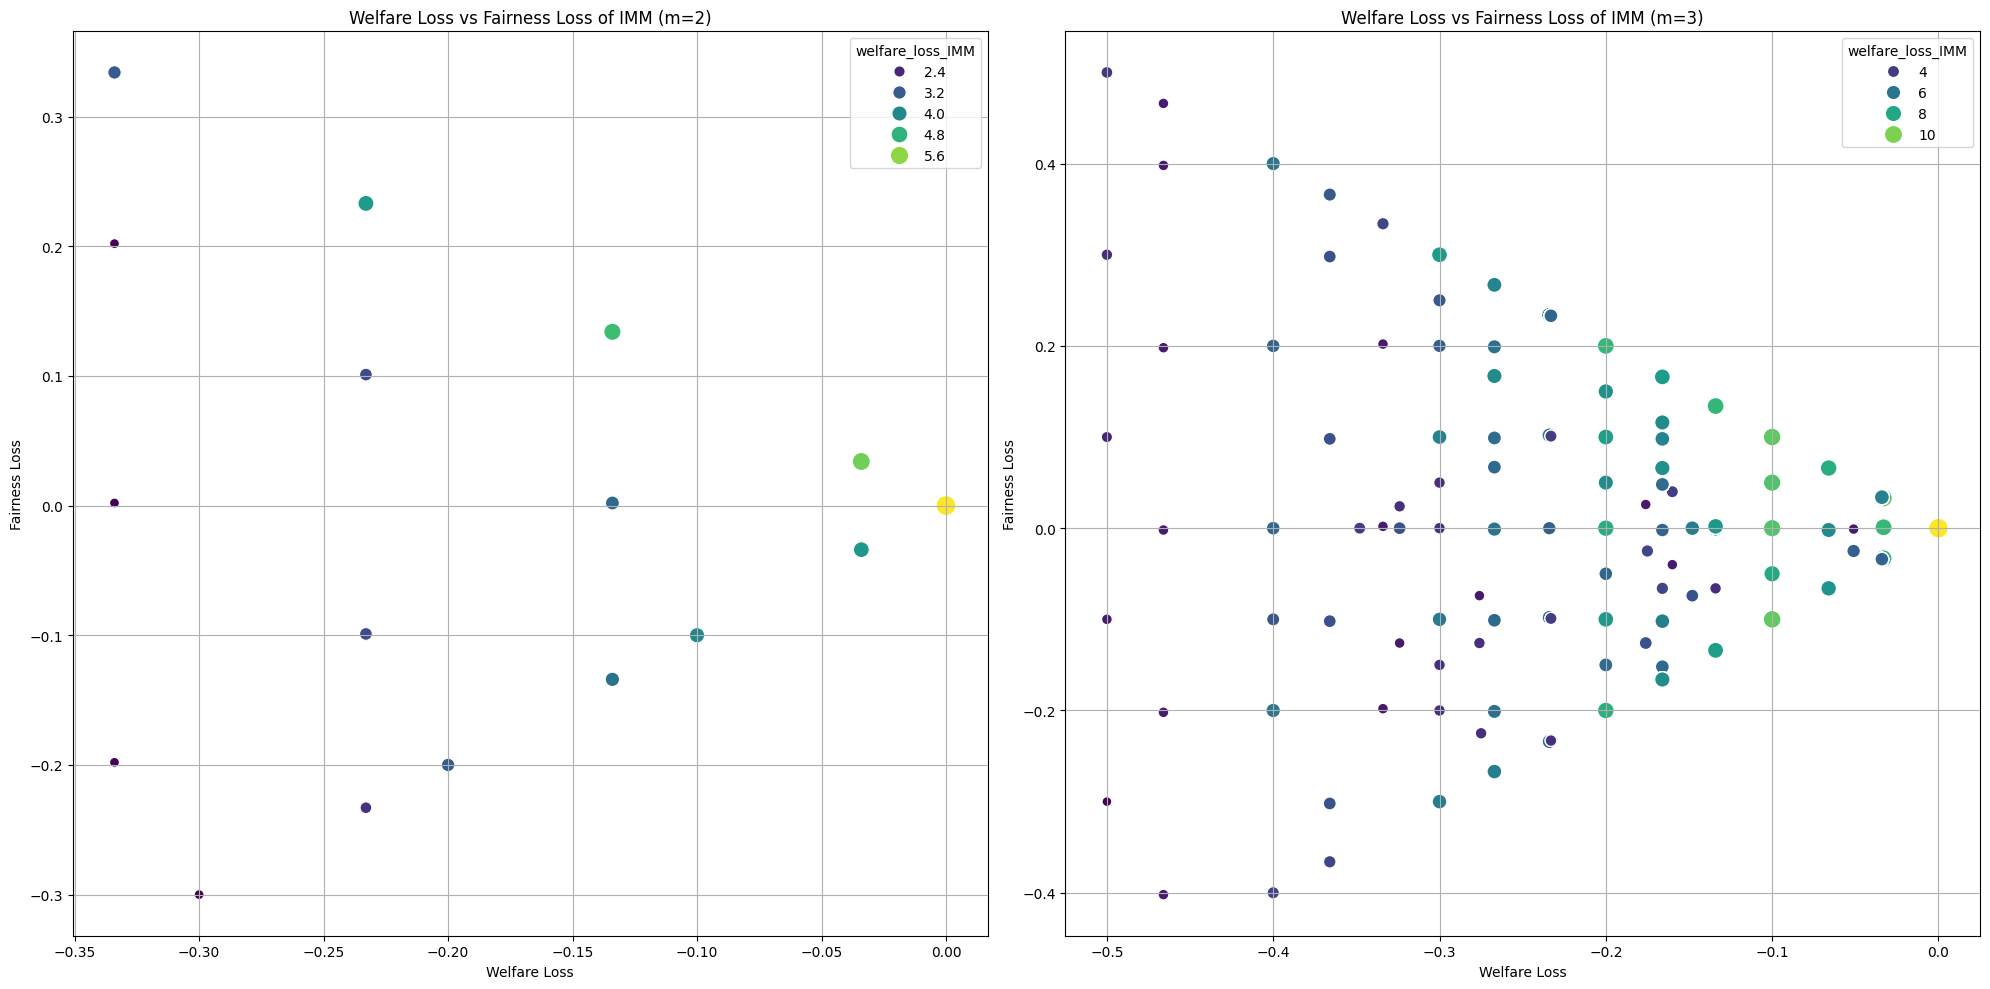

In [267]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
log_transform = lambda x: np.log1p(x)

# Plot for welfare vs fairness loss of IMM (m=2) with dynamic frequency calculation
sns.scatterplot(
    data=df,
    x='welfare_loss_IMM',
    y='fairness_loss_IMM',
    size=log_transform(df.groupby(['welfare_loss_IMM', 'fairness_loss_IMM'])['welfare_loss_IMM'].transform('count')),
    hue=log_transform(df.groupby(['welfare_loss_IMM', 'fairness_loss_IMM'])['welfare_loss_IMM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[0]
)
axes[0].set_title('Welfare Loss vs Fairness Loss of IMM (m=2)')
axes[0].set_xlabel('Welfare Loss')
axes[0].set_ylabel('Fairness Loss')
axes[0].grid(True)

# Plot for welfare vs fairness loss of IMM (m=3) with dynamic frequency calculation
sns.scatterplot(
    data=df4,
    x='welfare_loss_IMM',
    y='fairness_loss_IMM',
    size=log_transform(df4.groupby(['welfare_loss_IMM', 'fairness_loss_IMM'])['welfare_loss_IMM'].transform('count')),
    hue=log_transform(df4.groupby(['welfare_loss_IMM', 'fairness_loss_IMM'])['welfare_loss_IMM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[1]
)
axes[1].set_title('Welfare Loss vs Fairness Loss of IMM (m=3)')
axes[1].set_xlabel('Welfare Loss')
axes[1].set_ylabel('Fairness Loss')
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

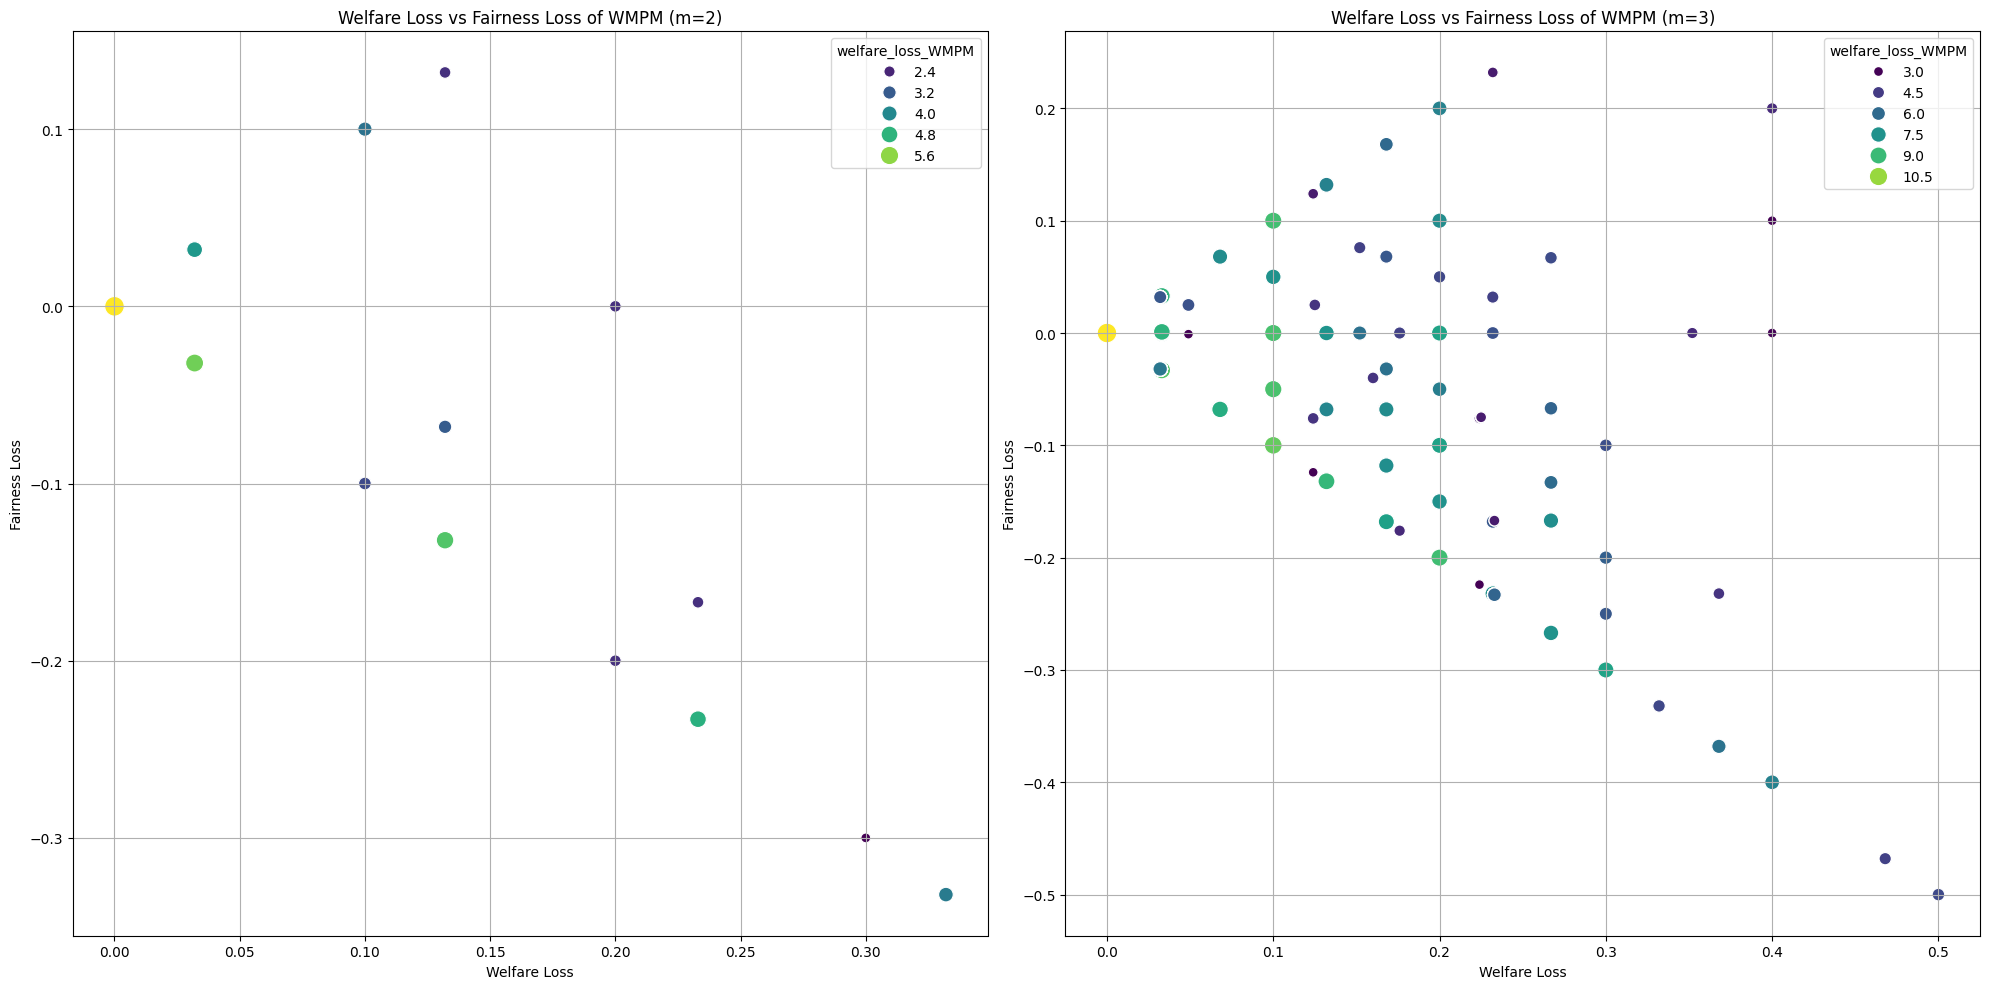

In [276]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
log_transform = lambda x: np.log1p(x)

# Plot for welfare vs fairness loss of WMPM (m=2) with dynamic frequency calculation
sns.scatterplot(
    data=df,
    x='welfare_loss_WMPM',
    y='fairness_loss_WMPM',
    size=log_transform(df.groupby(['welfare_loss_WMPM', 'fairness_loss_WMPM'])['welfare_loss_WMPM'].transform('count')),
    hue=log_transform(df.groupby(['welfare_loss_WMPM', 'fairness_loss_WMPM'])['welfare_loss_WMPM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[0]
)
axes[0].set_title('Welfare Loss vs Fairness Loss of WMPM (m=2)')
axes[0].set_xlabel('Welfare Loss')
axes[0].set_ylabel('Fairness Loss')
axes[0].grid(True)

# Plot for welfare vs fairness loss of WMPM (m=3) with dynamic frequency calculation
sns.scatterplot(
    data=df4,
    x='welfare_loss_WMPM',
    y='fairness_loss_WMPM',
    size=log_transform(df4.groupby(['welfare_loss_WMPM', 'fairness_loss_WMPM'])['welfare_loss_WMPM'].transform('count')),
    hue=log_transform(df4.groupby(['welfare_loss_WMPM', 'fairness_loss_WMPM'])['welfare_loss_WMPM'].transform('count')),
    palette='viridis',
    sizes=(50, 200),
    ax=axes[1]
)
axes[1].set_title('Welfare Loss vs Fairness Loss of WMPM (m=3)')
axes[1].set_xlabel('Welfare Loss')
axes[1].set_ylabel('Fairness Loss')
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [248]:
df4

,P,allocation_IMM,allocation_WMPM,allocation_C,total_disutility_IMM,total_disutility_WMPM,total_disutility_C,max_disutility_IMM,max_disutility_WMPM,max_disutility_C,welfare_loss_IMM,welfare_loss_WMPM,fairness_loss_IMM,fairness_loss_WMPM
0,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
1,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.1, 0.9]]","[0.0, 0.1, 0.9]","[0.0, 0.0, 1.0]","[0.0, 0.05, 0.95]",0.400,0.2,0.300,0.200,0.2,0.100,-0.100,0.100,-0.100,-0.100
2,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.2, 0.8]]","[0.0, 0.2, 0.8]","[0.0, 0.0, 1.0]","[0.0, 0.1, 0.9]",0.800,0.4,0.600,0.400,0.4,0.200,-0.200,0.200,-0.200,-0.200
3,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.3, 0.7]]","[0.0, 0.3, 0.7]","[0.0, 0.0, 1.0]","[0.0, 0.15, 0.85]",1.200,0.6,0.900,0.600,0.6,0.300,-0.300,0.300,-0.300,-0.300
4,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.4, 0.6]]","[0.0, 0.333, 0.667]","[0.0, 0.0, 1.0]","[0.0, 0.166, 0.834]",1.466,0.8,1.132,0.666,0.8,0.468,-0.334,0.332,-0.198,-0.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287491,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.8, 0.1, 0.1]]","[0.8, 0.1, 0.1]","[1.0, 0.0, 0.0]","[0.9, 0.05, 0.05]",0.800,0.4,0.600,0.400,0.4,0.200,-0.200,0.200,-0.200,-0.200
287492,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]]","[0.8, 0.2, 0.0]","[1.0, 0.0, 0.0]","[0.9, 0.1, 0.0]",0.800,0.4,0.600,0.400,0.4,0.200,-0.200,0.200,-0.200,-0.200
287493,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.9, 0.0, 0.1]]","[0.9, 0.0, 0.1]","[1.0, 0.0, 0.0]","[0.95, 0.0, 0.05]",0.400,0.2,0.300,0.200,0.2,0.100,-0.100,0.100,-0.100,-0.100
287494,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.9, 0.1, 0.0]]","[0.9, 0.1, 0.0]","[1.0, 0.0, 0.0]","[0.95, 0.05, 0.0]",0.400,0.2,0.300,0.200,0.2,0.100,-0.100,0.100,-0.100,-0.100


Muanal Input

In [238]:
n=3
m=3
P = [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
P = np.array(P)

a = independent_market_mechanism(n, m, P)
a

(array([1., 0., 0.]),
 [{'alternative': 1,
   'votes': [1.0, 1.0, 1.0],
   'phantoms': [1.0, 1.0, 0.5, 0.0],
   'combined_list': [0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0],
   'median': np.float64(1.0)},
  {'alternative': 2,
   'votes': [0.0, 0.0, 0.0],
   'phantoms': [1.0, 1.0, 0.5, 0.0],
   'combined_list': [0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0],
   'median': np.float64(0.0)},
  {'alternative': 3,
   'votes': [0.0, 0.0, 0.0],
   'phantoms': [1.0, 1.0, 0.5, 0.0],
   'combined_list': [0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0],
   'median': np.float64(0.0)}])